**OCD Patient Dataset: Demographics & Clinical Data**

The "OCD Patient Dataset: Demographics & Clinical Data" provides a detailed profile of 1,500 individuals diagnosed with Obsessive-Compulsive Disorder (OCD), offering valuable insights into both demographic and clinical aspects. The dataset captures essential demographic details such as age, gender, ethnicity, marital status, and education level, giving a comprehensive overview of the patient population.

Clinically, the dataset includes information on the date of diagnosis, symptom duration, and any previous psychiatric diagnoses, which help contextualize each patient's medical history. It further categorizes OCD symptoms into obsessions and compulsions, with severity measured using Yale-Brown Obsessive-Compulsive Scale (Y-BOCS) scores for both types of symptoms.

In addition, the dataset highlights any co-occurring mental health conditions such as depression or anxiety and provides detailed information on the medications prescribed to patients, offering a glimpse into treatment strategies. It also records whether patients have a family history of OCD, allowing for the exploration of potential genetic or environmental influences on the disorder. This dataset is a valuable resource for research into OCD’s demographic patterns, symptomatology, and treatment approaches.


In [1]:
!pip install shap

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sklearn
import shap
from sklearn.preprocessing import OneHotEncoder


# EDA

##dataset

In [3]:
from google.colab import files
uploaded = files.upload()

Saving ocd_patient_dataset.csv to ocd_patient_dataset (6).csv


In [4]:

df = pd.read_csv("ocd_patient_dataset.csv")
df.head()
df


,Patient ID,Age,Gender,Ethnicity,Marital Status,Education Level,OCD Diagnosis Date,Duration of Symptoms (months),Previous Diagnoses,Family History of OCD,Obsession Type,Compulsion Type,Y-BOCS Score (Obsessions),Y-BOCS Score (Compulsions),Depression Diagnosis,Anxiety Diagnosis,Medications
0,1018,32,Female,African,Single,Some College,2016-07-15,203,MDD,No,Harm-related,Checking,17,10,Yes,Yes,SNRI
1,2406,69,Male,African,Divorced,Some College,2017-04-28,180,NaN,Yes,Harm-related,Washing,21,25,Yes,Yes,SSRI
2,1188,57,Male,Hispanic,Divorced,College Degree,2018-02-02,173,MDD,No,Contamination,Checking,3,4,No,No,Benzodiazepine
3,6200,27,Female,Hispanic,Married,College Degree,2014-08-25,126,PTSD,Yes,Symmetry,Washing,14,28,Yes,Yes,SSRI
4,5824,56,Female,Hispanic,Married,High School,2022-02-20,168,PTSD,Yes,Hoarding,Ordering,39,18,No,No,NaN


In [5]:
df.shape

(1500, 17)

####Basic EDA

In [6]:
# Handle Missing Values
df['Previous Diagnoses'].fillna('No Previous Diagnoses', inplace=True)
df['Medications'].fillna('No Medications', inplace=True)

# Drop columns
df.drop('OCD Diagnosis Date', axis=1, inplace=True)

# Datatype
df['Depression Diagnosis'] = df['Depression Diagnosis'].map({'Yes': 1, 'No': 0})
df['Family History of OCD'] = df['Family History of OCD'].map({'Yes': 1, 'No': 0})
df['Anxiety Diagnosis'] = df['Anxiety Diagnosis'].map({'yes': 1, 'no': 0})
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})


# OneHotEncode
# Compulsion Type
compulsion_types = df['Compulsion Type'].unique()
ohe = OneHotEncoder(handle_unknown='ignore')
encoded_compulsion_types = ohe.fit_transform(df[['Compulsion Type']])
encoded_column_names = [f"Compulsion_Type_{compulsion_type}" for compulsion_type in compulsion_types]
encoded_df = pd.DataFrame(encoded_compulsion_types.toarray(), columns=encoded_column_names)
df = pd.concat([df, encoded_df], axis=1)
df.drop('Compulsion Type', axis=1, inplace=True)

# Medications
medications = df['Medications'].unique()
ohe = OneHotEncoder(handle_unknown='ignore')
encoded_medications = ohe.fit_transform(df[['Medications']])
encoded_column_names = [f"Medications_{medication}" for medication in medications]
encoded_df = pd.DataFrame(encoded_medications.toarray(), columns=encoded_column_names)
df = pd.concat([df, encoded_df], axis=1)
df.drop('Medications', axis=1, inplace=True)

# One-hot encoding for Ethnicity
ethnicities = df['Ethnicity'].unique()
ohe = OneHotEncoder(handle_unknown='ignore')
encoded_ethnicities = ohe.fit_transform(df[['Ethnicity']])
encoded_ethnicity_column_names = [f"Ethnicity_{ethnicity}" for ethnicity in ethnicities]
encoded_ethnicity_df = pd.DataFrame(encoded_ethnicities.toarray(), columns=encoded_ethnicity_column_names)
df = pd.concat([df, encoded_ethnicity_df], axis=1)
df.drop('Ethnicity', axis=1, inplace=True)

# One-hot encoding for Marital Status
marital_statuses = df['Marital Status'].unique()
ohe = OneHotEncoder(handle_unknown='ignore')
encoded_marital_statuses = ohe.fit_transform(df[['Marital Status']])
encoded_marital_status_column_names = [f"Marital Status_{status}" for status in marital_statuses]
encoded_marital_status_df = pd.DataFrame(encoded_marital_statuses.toarray(), columns=encoded_marital_status_column_names)
df = pd.concat([df, encoded_marital_status_df], axis=1)
df.drop('Marital Status', axis=1, inplace=True)

# One-hot encoding for Education Level
education_levels = df['Education Level'].unique()
ohe = OneHotEncoder(handle_unknown='ignore')
encoded_education_levels = ohe.fit_transform(df[['Education Level']])
encoded_education_level_column_names = [f"Education Level_{level}" for level in education_levels]
encoded_education_level_df = pd.DataFrame(encoded_education_levels.toarray(), columns=encoded_education_level_column_names)
df = pd.concat([df, encoded_education_level_df], axis=1)
df.drop('Education Level', axis=1, inplace=True)

# One-hot encoding for Previous Diagnoses
previous_diagnoses = df['Previous Diagnoses'].unique()
ohe = OneHotEncoder(handle_unknown='ignore')
encoded_previous_diagnoses = ohe.fit_transform(df[['Previous Diagnoses']])
encoded_previous_diagnosis_column_names = [f"Previous Diagnoses_{diagnosis}" for diagnosis in previous_diagnoses]
encoded_previous_diagnosis_df = pd.DataFrame(encoded_previous_diagnoses.toarray(), columns=encoded_previous_diagnosis_column_names)
df = pd.concat([df, encoded_previous_diagnosis_df], axis=1)
df.drop('Previous Diagnoses', axis=1, inplace=True)

# One-hot encoding for Obsession Type
obsession_types = df['Obsession Type'].unique()
ohe = OneHotEncoder(handle_unknown='ignore')
encoded_obsession_types = ohe.fit_transform(df[['Obsession Type']])
encoded_obsession_type_column_names = [f"Obsession Type_{type}" for type in obsession_types]
encoded_obsession_type_df = pd.DataFrame(encoded_obsession_types.toarray(), columns=encoded_obsession_type_column_names)
df = pd.concat([df, encoded_obsession_type_df], axis=1)
df.drop('Obsession Type', axis=1, inplace=True)

print(df.dtypes)


Patient ID                                    int64
Age                                           int64
Gender                                        int64
Duration of Symptoms (months)                 int64
Family History of OCD                         int64
Y-BOCS Score (Obsessions)                     int64
Y-BOCS Score (Compulsions)                    int64
Depression Diagnosis                          int64
Anxiety Diagnosis                           float64
Compulsion_Type_Checking                    float64
Compulsion_Type_Washing                     float64
Compulsion_Type_Ordering                    float64
Compulsion_Type_Praying                     float64
Compulsion_Type_Counting                    float64
Medications_SNRI                            float64
Medications_SSRI                            float64
Medications_Benzodiazepine                  float64
Medications_No Medications                  float64
Ethnicity_African                           float64
Ethnicity_Hi

,Patient ID,Age,Gender,Duration of Symptoms (months),Family History of OCD,Y-BOCS Score (Obsessions),Y-BOCS Score (Compulsions),Depression Diagnosis,Anxiety Diagnosis,Compulsion_Type_Checking,...,Previous Diagnoses_MDD,Previous Diagnoses_No Previous Diagnoses,Previous Diagnoses_PTSD,Previous Diagnoses_GAD,Previous Diagnoses_Panic Disorder,Obsession Type_Harm-related,Obsession Type_Contamination,Obsession Type_Symmetry,Obsession Type_Hoarding,Obsession Type_Religious
0,1018,32,1,203,0,17,10,1,NaN,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2406,69,0,180,1,21,25,1,NaN,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1188,57,0,173,0,3,4,0,NaN,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,6200,27,1,126,1,14,28,1,NaN,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,5824,56,1,168,1,39,18,0,NaN,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


## Analytical questions


### Which types of compulsions are most associated with depression?

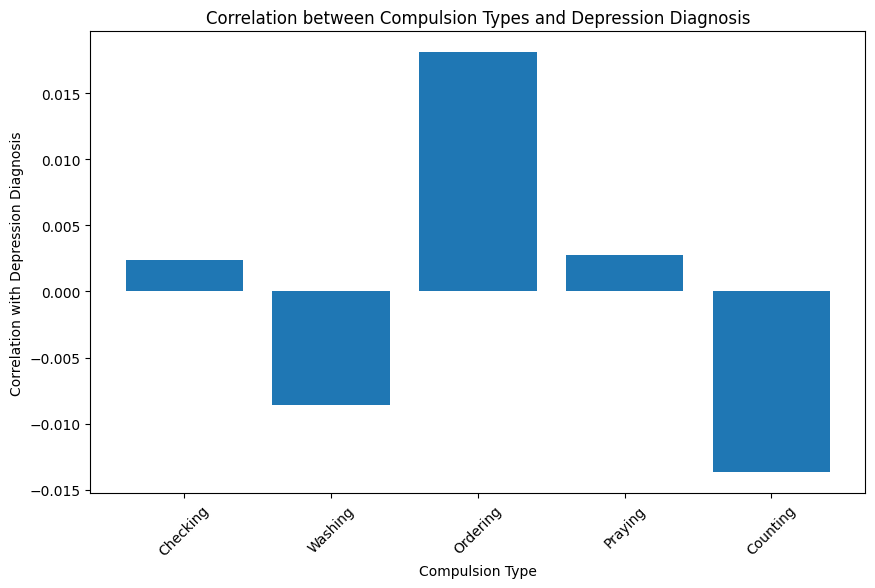

In [7]:
#code:

# Calculate the correlation between each compulsion type and Depression Diagnosis
correlations = df[['Compulsion_Type_Checking', 'Compulsion_Type_Washing', 'Compulsion_Type_Ordering',
                   'Compulsion_Type_Praying', 'Compulsion_Type_Counting', 'Depression Diagnosis']].corr()['Depression Diagnosis'][:-1]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(correlations)), correlations)
plt.xticks(range(len(correlations)), ['Checking', 'Washing', 'Ordering', 'Praying', 'Counting'], rotation=45)
plt.xlabel('Compulsion Type')
plt.ylabel('Correlation with Depression Diagnosis')
plt.title('Correlation between Compulsion Types and Depression Diagnosis')
plt.show()



###  What medications are most prescribed to OCD patients with depression?

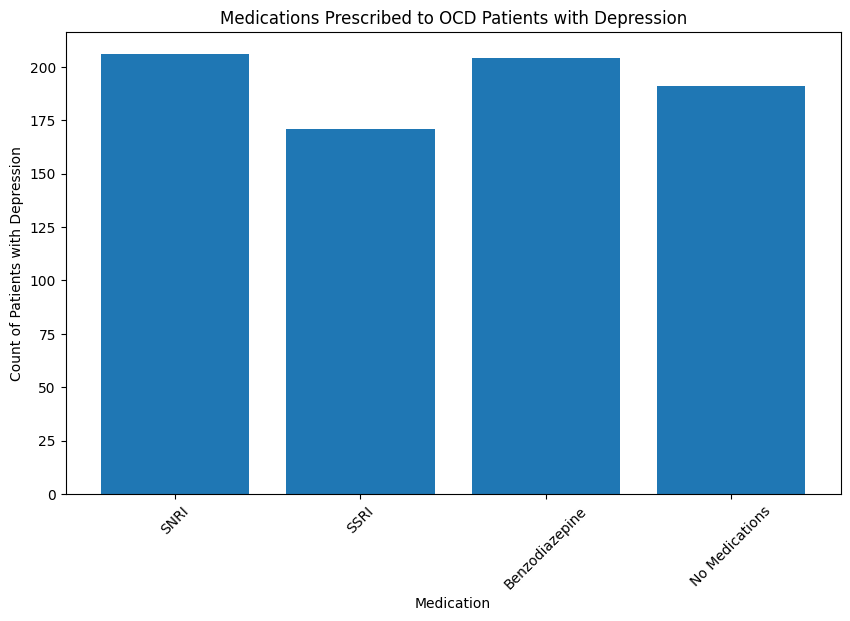

In [8]:
#code:
# Filter the data to only include OCD patients with depression
depressed_patients = df[df['Depression Diagnosis'] == 1]

# Calculate the count of patients prescribed each medication
medication_counts = depressed_patients[['Medications_SNRI', 'Medications_SSRI', 'Medications_Benzodiazepine', 'Medications_No Medications']].sum()

# Graphic
plt.figure(figsize=(10, 6))
plt.bar(range(len(medication_counts)), medication_counts)
plt.xticks(range(len(medication_counts)), ['SNRI', 'SSRI', 'Benzodiazepine', 'No Medications'], rotation=45)
plt.xlabel('Medication')
plt.ylabel('Count of Patients with Depression')
plt.title('Medications Prescribed to OCD Patients with Depression')
plt.show()

### How many OCD patients have a family history of OCD?

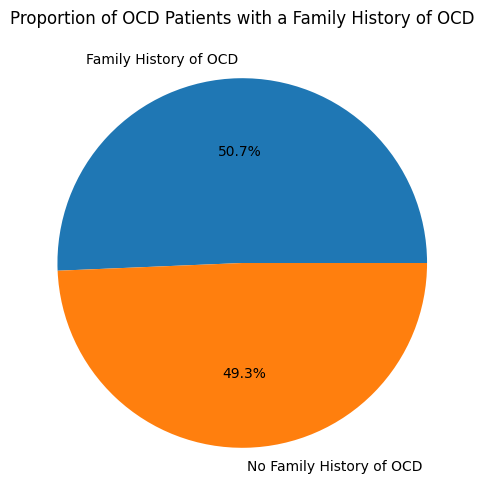

In [9]:
# Code
#Calculate the proportion of patients with and without a family history of OCD
family_history_proportions = [df['Family History of OCD'].value_counts()[1], df['Family History of OCD'].value_counts()[0]]

# graphic
plt.figure(figsize=(8, 6))
plt.pie(family_history_proportions, labels=['Family History of OCD', 'No Family History of OCD'], autopct='%1.1f%%')
plt.title('Proportion of OCD Patients with a Family History of OCD')
plt.show()